# Bike renting prediction
### **Yassine Ghouzam, PhD**
#### 24/10/2017


* **1 Apercu des données **
    * 1.1 Chargement des données/packages
    * 1.2 Exploration primiaire des données
* **2 Analyse exploratoire **
    * 3.1 Analyse du nombre de location de vélos
    * 3.2 Facteurs temporels
    * 3.3 Facteurs météorologiques
* **3 Transformation des descripteurs **
    * 3.1 Variables catégoriques
    * 3.2 Variables numériques
        * 5.2.1 Reduction de l'asymétrie (skewness) (Log transformation)
    * 3.3 Gestion des valeurs manquantes
* **4 Modélisation **
    * 4.1 Critére de performance
    * 4.2 Random Forest
        * 4.2.1 Validation croisée
        * 4.2.2 Courbes d'apprentissage et de validation
        * 4.2.3 Importance des descripteurs
    * 4.3 Prédiction
        * 4.3.1 Analyse des résultats de la prédiction
        * 4.3.2 Analyse residuel
    

## 1. Apercu des données
### 1.1 Chargement des données packages

In [1]:
######################################
####### Version Python : 3.5 #########
######################################
# Chargement des packages necessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split,learning_curve
from sklearn.ensemble import RandomForestRegressor 
from sklearn.dummy import DummyRegressor

from scipy import stats

%matplotlib inline

# Rend silencieux le script des warnings
warnings.filterwarnings('ignore')

# Definit le style des figures
sns.set(style='white', context='notebook', palette='deep')

In [2]:
# Chargement des donnees 
dataset = pd.read_csv("data.csv")

# Verifications des donnes
print("Le jeu de données est composé de %d lignes et %d colonnes"%(dataset.shape))

Le jeu de données est composé de 10886 lignes et 12 colonnes


### 1.2 Exploration primaire des données

In [3]:
# Quelques lignes du jeu de données
print(dataset.head())

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  


Voici un extrait du jeu de données, ce que l'on peut déja noter c'est la variable windspeed qui contient des valeurs à 0. 

In [4]:
# Affiche les types des différents descripteurs
print(dataset.dtypes)

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


Le descripteur datetime est de type 'object' (string dans pandas), nous allons le mettre au format 'datetime64[ns]' pour efféctuer des opérations dessus et ainsi extraire différentes informations nécessaires comme l'heure, le jour de la semaine ... 

In [5]:
# La date et l'heure ont besoin d'etre dans un format particulier
dataset["datetime"] = pd.to_datetime(dataset["datetime"])

# Extrait l'année
dataset["year"] = dataset["datetime"].dt.year

# Extrait le mois
dataset["month"] = dataset["datetime"].dt.month

# Extrait l'heure
dataset["hour"] = dataset["datetime"].dt.hour

# Extrait le jour de la semaine (de 0 pour lundi à 6 pour dimanche) 
dataset["weekday"] = dataset["datetime"].dt.weekday

# Retire le descripteur datetime de dataset
dataset = dataset.drop(labels = "datetime",axis = 1)

Une fois les différentes informations extraites, on retire ce descripteur du dataset.

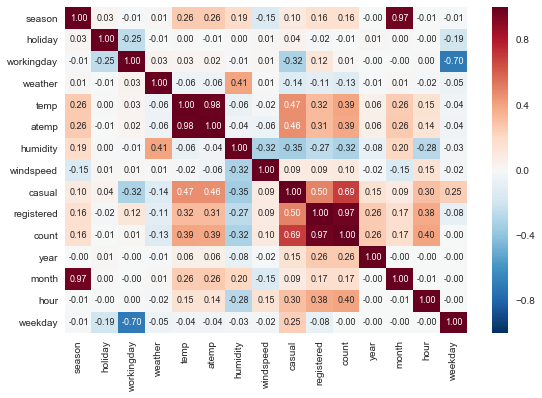

In [6]:
# Matrice de correlation
fig = plt.figure(figsize = (9,6))
ax = sns.heatmap(dataset.corr(),annot=True,fmt=".2f",annot_kws={"size":9});
fig.savefig("heatmap_corr.png")

Sur cette matrice de corrélation nous pouvons voir que la température ou la température ressentie ainsi que l’heure de location sont corrélées aux variables 'nombre de location de vélos' (abonnés et non abonnés). Il semblerait que le jour de la semaine influence également la demande en vélos de la part des usagers non abonnés (casual).
Le taux d’humidité est quant à lui anti-corrélé à la demande en vélo. 

La matrice de corrélation est un bon outil pour nous permettre de voir, dans un premiers temps, des tendances générales de dépendance direct ou indirect entre les descripteurs. En revanche on ne peut affirmer que les descripteurs peu ou pas corrélés n’ont pas d’influence sur la demande en vélos. En effet il peut exister des distributions multimodales. Pour l’affirmer il est nécessaire d’explorer de manière plus détaillée la relation entre ces descripteurs.

Avant cela, nous encodons les descripteurs catégoriques.

In [7]:
# Encodage des variables catégoriques
dataset["season"] = dataset["season"].map({1:"printemps", 2:"ete",
                                           3:"automne",4:"hiver"})

dataset["weather"] = dataset["weather"].map({1:"degage", 2:"brouillard",
                                             3:"Lpluie",4:"Fpluie"})

dataset["weekday"] = dataset["weekday"].map({0:"lundi", 1:"mardi",
                                             2:"mercredi",3:"jeudi",
                                             4:"vendredi",5:"samedi",
                                             6:"dimanche"})

categorical_features = ["season","weather","year","month","weekday","hour",
                        "holiday","workingday"]

for feat in categorical_features:
    dataset[feat] = dataset[feat].astype("category")
    
print(dataset.dtypes)

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
year          category
month         category
hour          category
weekday       category
dtype: object


Les différents descripteurs sont maintenant au bon format.



## 2. Analyse exploratoire 
### 2.1 Analyse du nombre de location de vélos
La variable d'intérêt dans cette étude est la variable count. Nous la notons variable aléatoire X 'nombre totale de location de vélos' qui est une quantitative et discrète. 

Jetons-y un oeil!

In [8]:
print(dataset["count"].describe())

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64


Il y a 192 locations de vélos en moyenne par heure. Mais il y a une grande fluctuation dans la location des vélos puisque l'écart type est de 181 locations. Le nombre minimal et maximal de location dans une heure est de 1 et 977 locations, réspectivement.
Regardons de plus prés la distribution de la variable count.

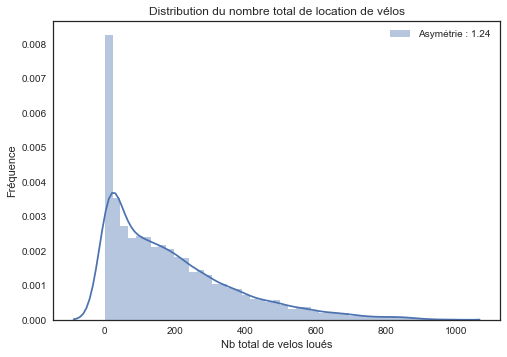

In [9]:
g = sns.distplot(dataset["count"])
g.set_xlabel("Nb total de velos loués")
g.set_ylabel("Fréquence")
g.legend(["Asymétrie : {:.2f}".format(dataset["count"].skew())])
g.set_title("Distribution du nombre total de location de vélos");

Il semblerait que la distribution du nombre total de locations de vélos ne suive pas une loi normale. Cette distribution ressemble plus à une distribution des valeurs extrêmes (Gumbel par exemple). 

Pour en être sur nous allons réaliser un test statistique.

Nous posons les hypothéses  
                           * H0 : Echantillon testé issu d'une population normalement distribuée.
                           * H1 : Echantillon testé non issu d'une population normalement distribuée.

Afin de tester H0, nous utilisons le test de normalité de Shapiro-Wilk.

Le seuil critique alpha est fixé à 5%.

In [10]:
alpha_risk = 0.05
statistic,pvalue = stats.shapiro(dataset["count"])

if pvalue < alpha_risk:
    print("Test significatif (pvalue = %.1e): Rejet de H0 (Distribution normale)\
au risque alpha=%.2f => le nombre total de location de vélos ne suit pas une \
distribution normale."%(pvalue,alpha_risk))
else :
    print("Test non significatif (pvalue = %.1e): Non rejet de H0 (Distribution\
normale) au risque alpha=%.2f => le nombre total de location de vélos suit \
une loi normale."%(pvalue,alpha_risk))

Test significatif (pvalue = 0.0e+00): Rejet de H0 (Distribution normale)au risque alpha=0.05 => le nombre total de location de vélos ne suit pas une distribution normale.


Le test de Shapiro-Wilk étant significatif, la variable aléatoire X ne suit pas une loi normale.

Nous utiliserons des tests non-paramétriques qui ne font pas d'assomption sur la distribution normale de la variable d'intérêt.

### 3.2 Facteurs temporels

Voyons dans un premier temps si le nombre total de location de vélos est différent sur les deux années étudiées.

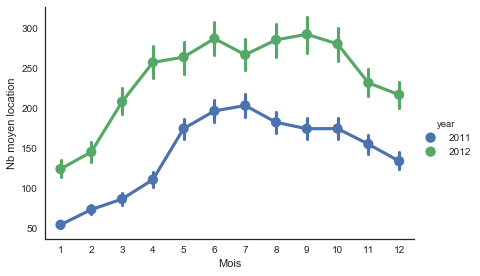

In [11]:
g = sns.factorplot(x="month",y="count",hue="year",data = dataset,aspect=1.5)
g.set_xlabels("Mois")
g.set_ylabels("Nb moyen location");

Le nombre moyen de location mensuel est incontestablement plus élevée au cours de l'année 2012.
Nous allons quand même nous assurer que cette différence apparente est bien significative.


Nous posons les hypothèses  
                            * H0 : Distribution de moyenne égale dans les deux populations des échantillons
                            * H1 : Distribution de moyenne inférieure dans la population de échantillon 1 (2011) par rapport à celle de l'échantillon 2 (2012) (test unilatéral)

Afin de tester H0, nous utilisons le test non paramétrique de Mann Whitney, idéal pour comparer deux échantillons indépendants.

Le seuil critique alpha est fixé à 5%.

In [12]:
count_2011 = dataset[dataset["year"] == 2011]["count"]
count_2012 = dataset[dataset["year"] == 2012]["count"]
# On test l'hypothése H0 et H1 
pvalue = stats.mannwhitneyu(count_2011,count_2012,alternative = "less").pvalue

if pvalue < alpha_risk:
    print("Test significatif (pvalue = %.1e) : Rejet de H0 (égalité des \
moyennes) au risque alpha=%.2f => il existe une différence \
significative du nombre de location de vélos entre \
2011 et 2012."%(pvalue,alpha_risk))
else :
    print("Test non significatif (pvalue = %.2e): Non rejet de H0 (égalité des \
moyennes) au risque alpha=%.2f => Nous ne pouvons pas affirmer qu'il \
existe une différence significative du nombre de vélos loués \
entre 2011 et 2012."%(pvalue,alpha_risk))

Test significatif (pvalue = 1.8e-116) : Rejet de H0 (égalité des moyennes) au risque alpha=0.05 => il existe une différence significative du nombre de location de vélos entre 2011 et 2012.


Le test est significatif, nous rejetons donc l'hypothèse H0 au risque alpha de 5%. Il y a bien donc une différence significative du nombre de vélos loués entre 2011 et 2012. La location est de vélos a été plus importante en 2012.

De la même manière nous allons vérifier s'il existe une différence selon les saisons. 

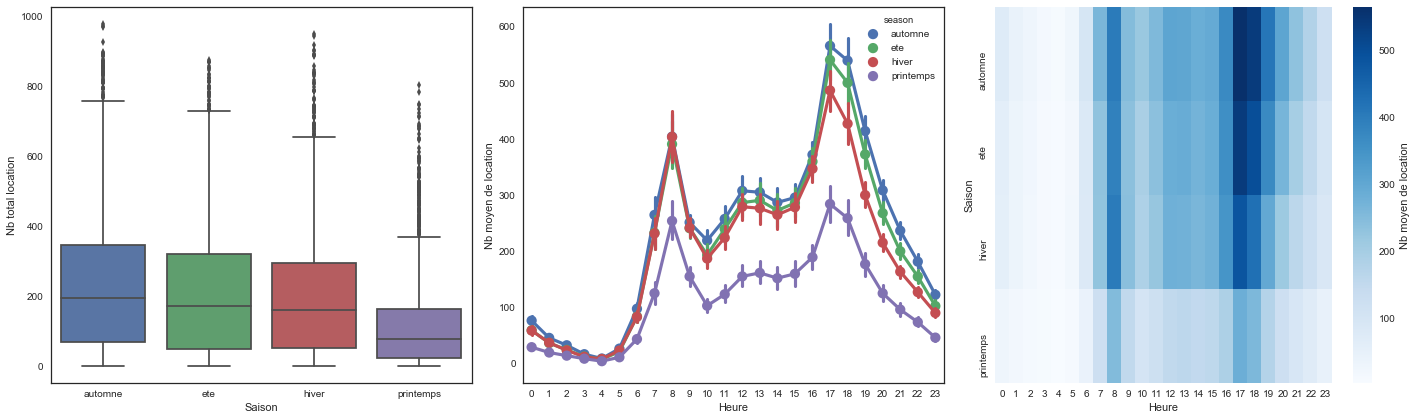

In [13]:
# Calcul la moyenne descripteurs pour chaque heures et chaque saisons
hour_season_group = dataset.groupby(by=["hour","season"]).mean()

# créer une dataframe 
df_hour_season_count = hour_season_group["count"].reset_index()

# Créer une dataframe du nb de vélos loués en fonction des saisons (en ligne) et des différentes heures (en colonne) 
df_hour_season_count = df_hour_season_count.pivot(index="season",
                                                  columns="hour",values="count")

fig, axes = plt.subplots(ncols=3,figsize=(20,6))

sns.boxplot(x="season",y="count",data=dataset,ax=axes[0])
axes[0].set_xlabel("Saison")
axes[0].set_ylabel("Nb total location")

sns.pointplot(x="hour",y="count",hue="season",data=dataset,aspect=1.5,ax=axes[1])
axes[1].set_xlabel("Heure")
axes[1].set_ylabel("Nb moyen de location")

sns.heatmap(df_hour_season_count,ax=axes[2],cmap="Blues",cbar_kws={'label': 'Nb moyen de location'})
axes[2].set_xlabel("Heure")
axes[2].set_ylabel("Saison")

plt.tight_layout()
plt.show()
plt.gcf().clear()

On note que la location de vélos est sensiblement similaire en été, hiver et automne. Les boxplots indiquent des médianes assez proches et l'évolution de la variable count au cours des heures de la journée semble similaire en été, hiver et automne avec deux pics (8h et 17h) correspondant aux heures pleines.
En revanche on note un faible nombre de location au printemps. Durant cette saison, l'évolution journalière est similaire aux trois autres saisons mais il y a moins de vélos loués. Cet effet est clairement visible sur la heatmap de droite.

Il semblerait donc que la saison soit un facteur influençant la demande en vélos. Nous allons vérifier cette hypothèse par un test statistique adapté. 

Nous posons les hypothèses  
                            * H0 : Distribution de la même médiane dans les k échantillons
                            * H1 : Distribution de médianes différentes dans les k échantillons

Afin de tester H0, nous utilisons le test non paramétrique de Kruskal Wallis pour comparer k échantillons indépendants.

Le seuil critique alpha est fixé à 5%.

In [14]:
# Ici la taille des données n'est pas un inconvenient
# Pour plus de lisibilité, je créer un dictionnaire contenant le nombre total 
# de velos loués pour chaque saison
season_count = {}
for season in dataset["season"].cat.categories:
    season_count[season] = dataset[dataset["season"] == season]["count"]

#Test statistique non-paramétrique de comparaison de k échantillons indépendants 
pvalue = stats.kruskal(season_count["printemps"],season_count["ete"],
              season_count["hiver"],season_count["automne"]).pvalue

if pvalue < alpha_risk:
    print("Test significatif (pvalue = %.1e): Rejet de H0 (égalité des médianes)\
au risque alpha=%.2f => il existe une difference significative \
du nombre de location de vélos pour les différentes saisons."%(pvalue,alpha_risk))
else :
    print("Test non significatif (pvalue = %.1e): Non rejet de H0 (égalité des\
médianes) au risque alpha=%.2f => Nous ne pouvons pas affirmer qu'il\
existe une difference significative du nombre de location de vélos pour les \
différentes saisons."%(pvalue,alpha_risk))

Test significatif (pvalue = 2.5e-151): Rejet de H0 (égalité des médianes)au risque alpha=0.05 => il existe une difference significative du nombre de location de vélos pour les différentes saisons.


Le test étant significatif, sous réserve d'un risque de 5% d'erreur, nous pouvons affirmer qu'il existe une différence significative du nombre de location de vélos durant les 4 saisons. **La saison est donc bien un facteur influent sur la demande en vélos.**

Regardons de plus près la demande en vélos selon les jours de la semaine.

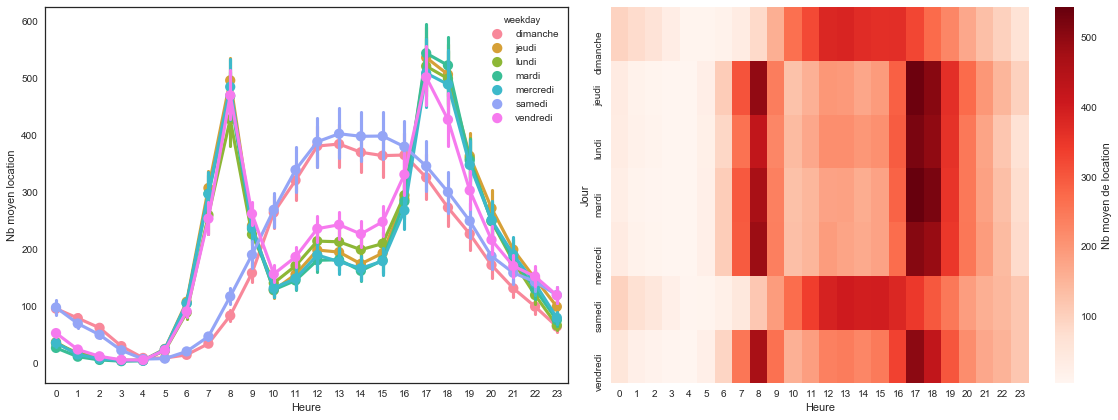

In [15]:
# Calcul la moyenne descripteurs pour chaque heures et chaque jours de la semaine
hour_weekday_group = dataset.groupby(by=["hour","weekday"]).mean()

# Créer une dataframe 
df_hour_weekday_count = hour_weekday_group["count"].reset_index()

# Créer une dataframe du nb de vélos loués en fonction des jours de la semaine (en ligne) et des différentes heures (en colonne) 
df_hour_weekday_count = df_hour_weekday_count.pivot(index="weekday",
                                            columns="hour",values="count")

fig, axes = plt.subplots(ncols=2,figsize=(16,6))

sns.pointplot(x="hour",y="count",hue="weekday",data=dataset,aspect=1.5,ax=axes[0])
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Nb moyen location")

sns.heatmap(df_hour_weekday_count,ax=axes[1],cmap="Reds",cbar_kws={'label': 'Nb moyen de location'})
axes[1].set_xlabel("Heure")
axes[1].set_ylabel("Jour")

plt.tight_layout()
plt.show()
plt.gcf().clear()

De prime abord il semble clair que la demande en vélos est différente selon le jour de la semaine considéré. Plus précisément  entre les jours de travail (lundi, mardi, mercredi, jeudi et vendredi) et les jours du weekend (samedi et dimanche). 
La location de vélos a un profil différent selon ces deux groupes de jours de la semaine. Les jours de travail sont ponctués par deux pics aux heures pleines (8h et 17h) tandis que les jours du weekend la demande est parabolique avec une augmentation de 5h jusqu'à 12h-15h et une diminution jusqu'a 5h.

D'ailleurs l'évolution de la demande en vélos selon les jours travaillés ou fériés, montre des similitudes. 

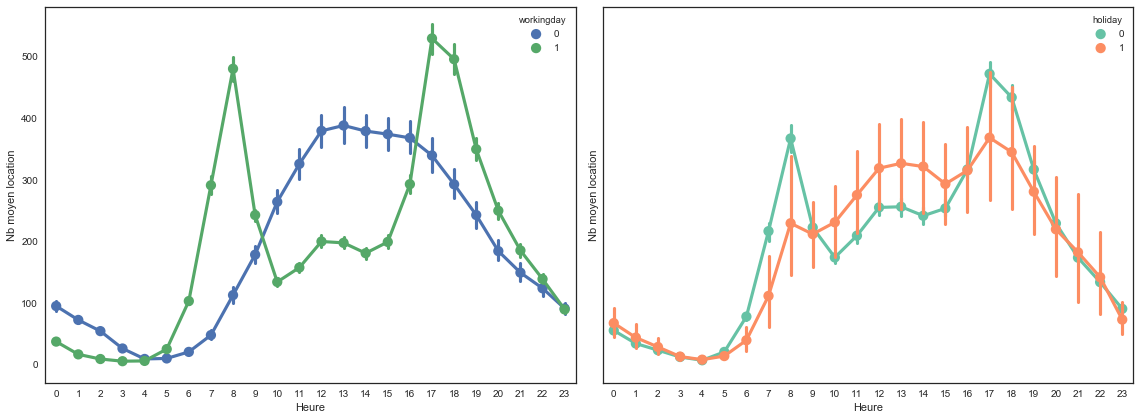

In [16]:
fig, axes = plt.subplots(ncols=2,figsize=(16,6),sharey=True)

sns.pointplot(x="hour",y="count",hue="workingday",data=dataset,aspect=1.5,ax=axes[0])
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Nb moyen location")

sns.pointplot(x="hour",y="count",hue="holiday",data=dataset,aspect=1.5,ax=axes[1],palette="Set2")
axes[1].set_xlabel("Heure")
axes[1].set_ylabel("Nb moyen location")

plt.tight_layout()
plt.show();
plt.gcf().clear()

Il semblerait donc que le jour de la semaine (plus précisément jour travaillé/non travaillé) soit un facteur influençant la demande en vélos. Nous allons vérifier cette hypothèse par un test statistique adapté. 

Nous posons les hypothèses  
                            * H0 : Distribution de moyenne égale dans les deux populations des échantillons
                            * H1 : Distribution de moyennes différentes dans les deux  populations des échantillons (test bilatéral)

Afin de tester H0, nous utilisons le test non paramétrique de Mann Whitney, pour comparer deux échantillons indépendants.

Le seuil critique alpha est fixé à 5%.

In [17]:
# Test non paramétrique de comparaison de deux échantillons indépendants
pvalue = stats.mannwhitneyu(dataset[dataset["workingday"] == 0]["count"],
                   dataset[dataset["workingday"] == 1]["count"],alternative="two-sided").pvalue

if pvalue < alpha_risk:
    print("Test significatif (pvalue = %.1e) : Rejet de H0 (égalité des \
moyennes) au risque alpha=%.2f => il existe une difference \
significative du nombre de location de vélos durant les jours travaillés \
et non travaillés"%(pvalue,alpha_risk))
else :
    print("Test non significatif (pvalue = %.1e): Non rejet de H0 (égalité des \
moyennes) au risque alpha=%.2f => Nous ne pouvons pas affirmer qu'il \
existe une difference significative du nombre de location de vélos durant \
les jours travaillés et non travaillés"%(pvalue,alpha_risk))

Test non significatif (pvalue = 9.7e-01): Non rejet de H0 (égalité des moyennes) au risque alpha=0.05 => Nous ne pouvons pas affirmer qu'il existe une difference significative du nombre de location de vélos durant les jours travaillés et non travaillés


Le test étant non significatif, nous ne pouvons pas affirmer que le nombre de location moyen est diffèrent selon les jours travaillés et non travaillés. En revanche l'évolution du nombre de location au cours de la journée est différente selon les jours weekend et les jours non weekend.

En revanche, cela semble plus difficle à voir en ce qui concerne les jours fériés. Un test statistique de Mann Whitney montre qu'il n'existe pas de différence significative du nombre de location moyen entre les jours fériés et non fériés.

### 3.3 Facteurs météorologiques

Selon les corrélations mises en évidence plus haut, la température ainsi que l'humidité sont fortement corrélées et anti-corrélées à la demande en location de vélos. Voyons cela ! 

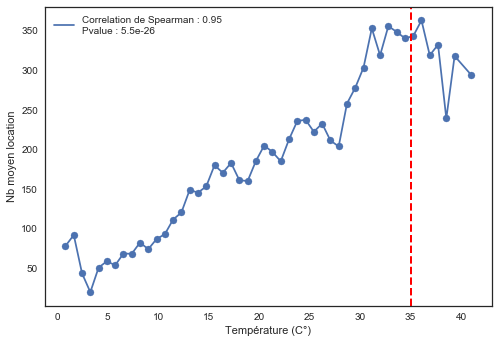

In [18]:
temp_mean_group = dataset.groupby(by="temp").mean().reset_index()

plt.scatter(data = temp_mean_group, x = "temp", y = "count")
plt.plot(temp_mean_group["temp"],temp_mean_group["count"])
plt.xlabel("Température (C°)")
plt.ylabel("Nb moyen location")
plt.axvline(x=35, ymin=0, ymax = 400, linewidth=2, color="r",linestyle='dashed')

# test de correlation de spearman
spearman_test = stats.spearmanr(temp_mean_group["temp"], temp_mean_group["count"]) 

plt.legend(["Correlation de Spearman : %.2f\nPvalue : %.1e"%(spearman_test.correlation, spearman_test.pvalue)]);

On remarque que le nombre de location de vélos augmente de manière quasi-linéaire avec la température. Cependant on note tout de même qu'au-delà de 35°C la demande en location diminue. Dans les cas rares où la chaleur est forte, les vélos sont délaissés par les usagers.

La variable count ne suivant pas une loi normale, nous préférons utiliser un test de corrélation de Spearman, non paramétrique, qui ne requiert par la condition de la normalité des distributions des deux variables comparées contrairement au test de corrélation de Pearson.

La pvalue du test de corrélation étant inférieure au risque alpha de 5% le test est significatif. La température moyenne ainsi que le nombre de location sont donc fortement corrélés. Il existe donc un lien linéaire significatif entre ces deux variables. 
** La température est incontestablement un facteur d'influence de la demande en location.**

Intéressons-nous maintenant à la relation entre le taux d'humidité et la demande en location.

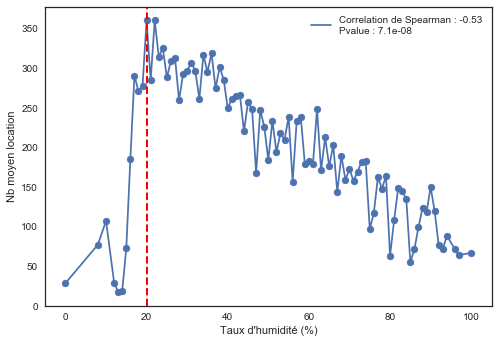

In [19]:
humidity_mean_group = dataset.groupby(by="humidity").mean().reset_index()

plt.scatter(data = humidity_mean_group, x = "humidity", y = "count")
plt.plot(humidity_mean_group["humidity"],humidity_mean_group["count"])
plt.xlabel("Taux d'humidité (%)")
plt.ylabel("Nb moyen location")
plt.axvline(x=20, ymin=0, ymax = 400, linewidth=2, color="r",linestyle='dashed')

# test de correlation de spearman
spearman_test = stats.spearmanr(humidity_mean_group["humidity"], humidity_mean_group["count"]) 

plt.legend(["Correlation de Spearman : %.2f\nPvalue : %.1e"%(spearman_test.correlation, spearman_test.pvalue)]);

Contrairement à la température, la demande en location de vélos diminue avec le taux d'humidité. La fréquentation augmente jusqu'au taux idéal de 20%, au-delà elle diminue.

La pvalue du test de corrélation de Spearman étant inférieure au risque alpha de 5% le test est significatif. Le taux d'humidité moyen ainsi que le nombre de location sont donc fortement négativement corrélés (anti-corrélés). Il existe donc un lien linéaire significatif entre ces deux variables. 
** Le taux d'humidité est incontestablement un facteur d'influence de la demande en location.**

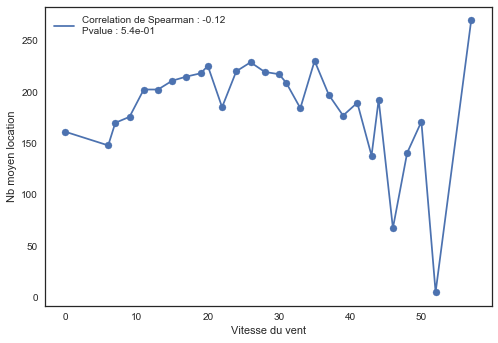

In [20]:
windspeed_mean_group = dataset.groupby(by="windspeed").mean().reset_index()

plt.scatter(data = windspeed_mean_group, x = "windspeed", y = "count")
plt.plot(windspeed_mean_group["windspeed"],windspeed_mean_group["count"])
plt.xlabel("Vitesse du vent")
plt.ylabel("Nb moyen location");

# test de correlation de spearman
spearman_test = stats.spearmanr(windspeed_mean_group["windspeed"], windspeed_mean_group["count"]) 

plt.legend(["Correlation de Spearman : %.2f\nPvalue : %.1e"%(spearman_test.correlation, spearman_test.pvalue)]);

Contrairement à la température et au taux d'humidité, la vitesse du vent ne semble pas avoir d'influence sur la demande en location. 

Le test de corrélation de spearman est non significatif (Pvalue > 0.05). On ne peut donc pas affirmer qu'il existe un lien entre la demande en location et la vitesse du vent.

## 3. Transformation des descripteurs
### 3.1 Variables catégoriques
Nous allons passer à la partie modélisation.
Avant cela il est necéssaire d'encoder les variables catégoriques en "one-hot", c'est à dire représenter des états en utilisant pour chacun une valeur dont la représentation est binaire {0,1}.

In [21]:
# Encodage des variables season, weather et weekday 'one hot encoding'
dataset = pd.get_dummies(dataset,columns=["season","weather","weekday"])

# On retire les varaibles registred et casual avant la modélisation
dataset = dataset.drop(labels = ["registered","casual"],axis = 1)

N'oublions pas de retirer les variables registered et casual, count étant la somme des deux.

### 3.2 Variables numériques

#### 3.2.1 Réduction de l'asymétrie (skewness) par transformation logarithmique

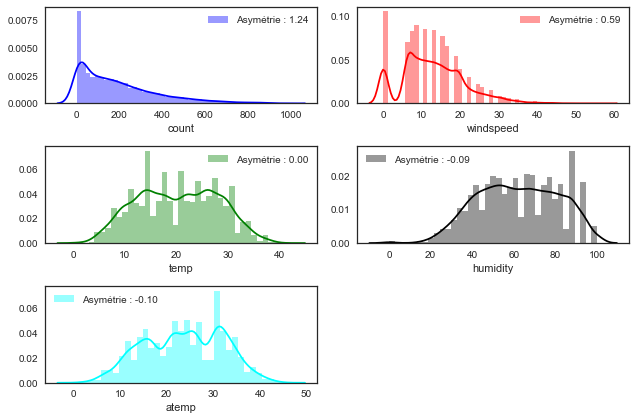

In [22]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(9,6))

sns.distplot(dataset["count"],ax =axes[0,0],color="b")
axes[0,0].legend(["Asymétrie : {:.2f}".format(dataset["count"].skew())])

sns.distplot(dataset["windspeed"],ax =axes[0,1],color="red")
axes[0,1].legend(["Asymétrie : {:.2f}".format(dataset["windspeed"].skew())])

sns.distplot(dataset["temp"],ax =axes[1,0],color="green")
axes[1,0].legend(["Asymétrie : {:.2f}".format(dataset["temp"].skew())])

sns.distplot(dataset["humidity"],ax =axes[1,1],color="black")
axes[1,1].legend(["Asymétrie : {:.2f}".format(dataset["humidity"].skew())])

sns.distplot(dataset["atemp"],ax =axes[2,0],color="cyan")
axes[2,0].legend(["Asymétrie : {:.2f}".format(dataset["atemp"].skew())])

axes[2,1].remove()

plt.tight_layout()
plt.show();
plt.gcf().clear()

Compte tenu de la faible asymétrie des distributions des variables numériques, une transofmation logarithmique n'est pas nécessaire. Cependant la distribution de la variable d'intéret count présente une légére asymétrie qui peut être corrigée. 
Cette transformation doit se faire ou non en fonction du critére de performance utilisé. Dans notre cas nous utiliserons le RMSE (Root Mean Square Error) et la transformation logarithmique aurait pour conséquence de diminuer légèrement les performances. En revanche dans le cas d'un critére tel que le RMLSE (Root Mean Squared Logarithmic Error), la transformation logarithmique des descripteurs numériques aurait été encouragée. 

### 3.3 Gestion des valeurs manquantes

Avant de créer notre modéle il est nécessaire de s'assurer que les eventuelles valeurs manquantes du jeu de données soient traitées.

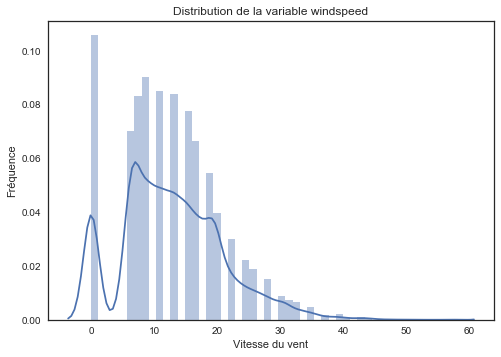

In [23]:
g = sns.distplot(dataset["windspeed"]);
g.set_xlabel("Vitesse du vent")
g.set_ylabel("Fréquence")
g.set_title("Distribution de la variable windspeed");

Parmi les descripteurs, seul windspeed contient des valeurs manquantes marquées par des zéros. 

La distribution de la variable windspeed montre une continuité à chaque intervales de valeur puis une forte fréquence bien distinct de valeur à zéros. Ceci semble indiquer que ces valeurs à zéros ne résulte pas d'une mesure du vent nulle mais plutôt de l'abscence de mesure (valeur manquante). 

Il s'agit de 1313 valeurs manquantes soit 12.06% des valeurs de windspeed. Au vu de la proportion relativement importante de ces valeurs manquantes, retirer les lignes contenant ces valeurs n'est pas une bonne solution. La meilleure stratégie serait de prédire ces valeurs manquantes.

In [24]:
# Gestion des valeurs manquantes de windspeed par prédiction
# Indices des valeurs manquantes et non manquantes
index_missing_ws = dataset[dataset["windspeed"] == 0].index
index_ws = dataset[dataset["windspeed"] != 0].index

# Jeu de données pour l'apprentissage de windspeed
X_train_ws = dataset.iloc[index_ws].drop(labels = "windspeed",axis = 1)
Y_train_ws = dataset["windspeed"].iloc[index_ws]

# Jeu de données pour la prediction de windspeed
X_test_ws = dataset.iloc[index_missing_ws].drop(labels = "windspeed",axis = 1)

Aprés avoir isolé un jeu d'apprentissage contenant les valeurs de windspeed.
J’ai choisi d’utiliser l’algorithme des Random Forests appliqué à la régression (Regression Forests), connu pour ses bonnes performances prédictives. 

In [25]:
# Graine aléatoire 
random_state = 42
# Séparateur de données en 10 échantillons pour la cross validation
kfold = KFold(n_splits=10,random_state = random_state)

# On définit le critére de performance
def RMSE(estimator,X_train, Y_train, cv=10,n_jobs=4):
    """ Retourne la valeur du RMSE aprés validation croisée """
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv
                        ,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

Pour l'évaluation des modéles , je choisi d'utiliser la procédure de validation croisée en 10 échantillons. Chaque echantillon sera selectioné comme un ensemble de validation et les (k-1) autres échantillons constitueront l'ensemble d'apprentissage. Cette méthode est robuste pour estimer de manière fiable le critére de performance quand la taille des echantillons est suffisamment importante.

In [26]:
RFR = RandomForestRegressor(n_estimators=50,random_state=random_state)

# On test la performance du Random forest par validation croisée 
print("Estimation du RMSE de la prédiction de windspeed avec le \
Random Forest, par validation croisée : %.2f"%RMSE(RFR,X_train_ws,Y_train_ws,cv=kfold))

Estimation du RMSE de la prédiction de windspeed avec le Random Forest, par validation croisée : 6.67


In [27]:
# On définit un regresseur qui renvoie la moyenne de l'échantillon d'apprentissage
Mean_regressor = DummyRegressor(strategy="mean")
# On test la performance de la prédiction en utilisant simplement la moyenne.
print("Estimation du RMSE de la prédiction de windspeed avec \
la moyenne, par validation croisée : %.2f"%RMSE(Mean_regressor,X_train_ws,Y_train_ws,cv=kfold))

Estimation du RMSE de la prédiction de windspeed avec la moyenne, par validation croisée : 7.05


A titre de comparaison, la performance de la prédiction de windspeed par Random Forest n'est pas tellement différente de celle d'un simple modéle qui  renvoie la moyenne de l'échantillon d'apprentissage. 

Au vu de ces mauvais résultats, une autre stratégie serait d'évaluer l'importance de windspeed pour la prédiction de la variable count et de décider quant au fait de la conserver ou pas. 

## 4. Modélisation
### 4.1 Critére de performance

Nous cherchons à prédire le nombre de location de vélos en une heure représenté par la variable count. 
Il s'agit d'une variable discrète et positive. Elle peut prendre des valeurs importantes et nous pouvons donc la considérer comme une variable continue.

Il s'agit donc d'un problème de régression et non de classification. Pour évaluer ma méthode de prédiction j’ai choisi comme critère de performance le RMSE (Root Mean Square Error) (Fonction définit plus haut).

Le RMSE est la racine carrée de la moyenne du carré des écarts entre les valeurs observées et prédites (erreurs de prédiction). Cette métrique à l'avantage de pénaliser de la même manière les prédictions trop élevées ou trop basses par rapport a leurs valeurs observées. Comme l'erreur est au carrée dans le RMSE cela a pour effet de pénaliser très fortement les erreurs de prédiction de grande amplitude.
Dans notre cas d'étude cela est important car les prédictions avec une forte amplitude d'erreur (par exemple une demande de location trop sous-estimée ou trop surestimée) peuvent mener à des pénuries de vélos ou à l'inverse à un sur investissement dans des vélos non loués.
Ainsi il est préférable d'avoir un modèle qui fasse beaucoup de petites erreurs plutôt que quelques erreurs de grande amplitude.

### 4.2 Random Forest
#### 4.2.1 Validation croisée

In [28]:
#############################
###### Machine learning #####
#############################

# Stock la variable à prédire dans un vecteur à part.
Y_train = dataset["count"]

# On retire la variable à prédire du jeu de données 
dataset = dataset.drop(labels = "count",axis = 1)

In [29]:
# Modélisation de la variable count

#RFR = RandomForestRegressor(random_state=random_state)
#
#rf_param_grid = {"max_depth": [None,5,10,50],
#              "max_features": ["auto","log2","sqrt"],
#              "bootstrap": [True, False],
#              "n_estimators" :[100,300,400,500],
#              "criterion": ["mse"]}
#
#gsRFR = GridSearchCV(RFR, param_grid = rf_param_grid, cv=kfold, scoring="neg_mean_squared_error",n_jobs=4, verbose = 0)
#gsRFR.best_estimator_

RFR = RandomForestRegressor(n_estimators=400, criterion = "mse", max_features= 'auto',
                            max_depth= None, bootstrap = True, random_state=random_state)

# On test la performance par validation croisée
print("Estimation du RMSE de la prédiction de count avec le \
Random Forest, par validation croisée : %.2f"%RMSE(RFR,dataset,Y_train,cv=kfold))

Estimation du RMSE de la prédiction de count avec le Random Forest, par validation croisée : 60.26


In [30]:
# On définit un regresseur qui renvoie la moyenne de l'échantillon d'apprentissage
Mean_regressor = DummyRegressor(strategy="mean")

# On test la performance de la prédiction en utilisant simplement la moyenne de count
print("Estimation du RMSE de la prédiction de count avec le \
la moyenne de count, par validation croisée : %.2f"%RMSE(Mean_regressor,dataset,Y_train,cv=kfold))

Estimation du RMSE de la prédiction de count avec le la moyenne de count, par validation croisée : 178.64


Pour prédire la demande en location, j’ai choisi d’utiliser l’algorithme des Random Forests appliqué à la régression (Regression Forests), connu pour ses bonnes performances prédictives.

Cette algorithme fait partie des méthodes ensemble. Il s'agit de combinaison de multiples arbres de décisions. L'idée est d'augmenter la performance de prédiction en combinant la prédiction de plusieurs arbres de décision entrainés sur des sous parties différentes du jeu d'apprentissage. Les prédictions sont ensuite combinées et moyennées pour donner une prédiction finale. 

Les paramètres utilisés sont les paramètres quasi optimaux que j'ai déterminés grâce à une approche par grille (Code commenté au-dessus). Le code est commenté car la recherche de paramètres optimaux prend plusieurs heures.

Le paramètre "n_estimators" est sans doute le plus important dans le random forest. Il permet de contrôler le nombre d'arbres de décision que contient le modèle. 
Un des paramètres important à surveiller est le "max_depth", il indique le niveau de profondeur des arbres de décision. Plus il est élevé plus le risque de sur-apprentissage est important. Ici il est mis à "None" c'est à dire qu'il n'y a aucune limite de profondeur d'arbre.

A titre de comparaison, la validation croisée indique une estimation du RMSE à 60.26 ce qui est nettement mieux que la prédiction en utilisant une moyenne (RMSE : 178.6).

Cependant il est nécessaire de vérifier si notre modèle n'est pas sujet au sur-apprentissage. 
Pour cela, j'ai tracé des courbes d'apprentissage et de validation pour notre modèle ainsi que pour la version avec un "max_depth" limité.

#### 4.2.2 Courbes d'apprentissage et de validation

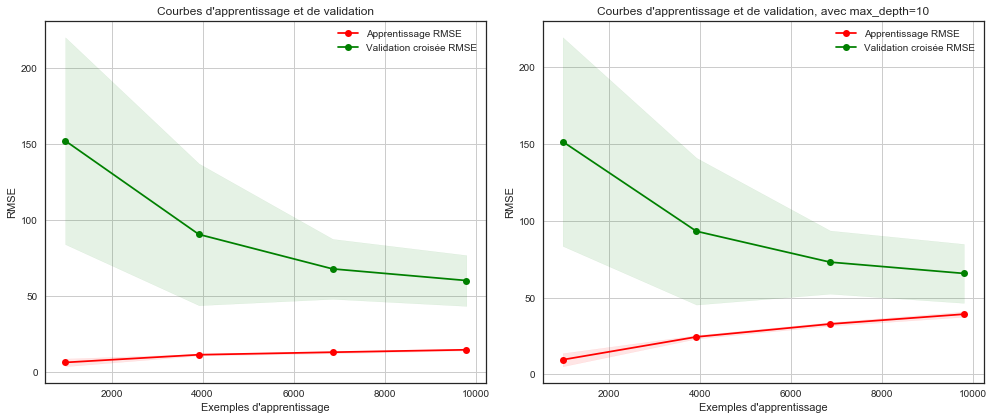

Estimation du RMSE de la prédiction de count avec le Random Forest (max_depth=10), par validation croisée : 65.75


In [31]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, axe = None, train_sizes=np.linspace(.1, 1.0, 4)):
    """Trace les courbes d'apprentissage et de validation """
    if axe == None:
        plt.figure()
        plt.title(title)
        plt.xlabel("Exemples d'apprentissage")
        plt.ylabel("RMSE")
    else :
        plt = axe
        plt.set_title(title)
        plt.set_xlabel("Exemples d'apprentissage")
        plt.set_ylabel("RMSE")
    
    if ylim is not None:
        plt.ylim(*ylim)        
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=n_jobs, 
        train_sizes=train_sizes)
    train_scores = np.sqrt(-train_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores = np.sqrt(-test_scores)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Apprentissage RMSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation croisée RMSE")

    plt.legend(loc="best")
    return plt

# Deuxiéme prédicteur Random Forest avec une profondeur des arbres limitée = 10 niveaux
RFR2 = RandomForestRegressor(n_estimators=50, criterion = "mse", max_features= 'auto',
                            max_depth= 10, bootstrap = True, random_state=random_state)

fig, axes = plt.subplots(ncols=2,figsize=(14,6))

plot_learning_curve(RFR,"Courbes d'apprentissage et de validation",dataset, Y_train, cv=kfold, axe = axes[0]);
plot_learning_curve(RFR2,"Courbes d'apprentissage et de validation, avec max_depth=10",dataset, Y_train, cv=kfold, axe = axes[1]);

plt.tight_layout()
plt.show();
plt.gcf().clear()

# On test la performance du Random Forest avec max_depth = 10 
print("Estimation du RMSE de la prédiction de count avec le \
Random Forest (max_depth=10), par validation croisée : %.2f"%RMSE(RFR2,dataset,Y_train,cv=kfold))

On note que pour notre premier modéle (graphique de  gauche), il existe un écart important entre la performance de la prédiction sur les données d'apprentissage et sur les données de validation. Le modèle à trés bien appris, mais n'est pas capable d'avoir des performances proches sur un jeu de donnée de validation. Il s'agit ici de sur-apprentissage. 

En revanche avec notre second modéle incluant une limite de profondeur de 10 niveaux (max_depth =10), le modéle est nettement moins sujet au sur-apprentissage. En effet, comme on peut le voir sur le graphique de droite, la courbe de validation se raproche nettement de la courbe d'apprentissage. Ceci indique que notre deuxiéme modéle de random forest a une capacité de généralisation meilleure que le premier modèle.

Il est clair que nous perdons légèrement en performance générale en limitant le modéle avec une profondeur maximale des arbres à 10 niveaux, mais notre modéle est plus robuste et sera meilleur sur des données complétement nouvelles. Pour la suite, nous choisirons donc ce deuxiéme modéle.

#### 4.2.3 Sélection et importances des descripteurs
Voyons maintenant l'impact de la variable windspeed et des autres descripteurs sur la performance de la prédiction.

In [32]:
# Apprentissage
RFR2.fit(dataset,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Une fois le modéle établie, nous allons regarder l'importance des descripteurs. Un des avantages du random forest est de présenter un estimation de l'importance des variables du modéle. Cette mesure est relative, plus le descripteur est impliqué en amont des arbres de decisions plus il est important. 

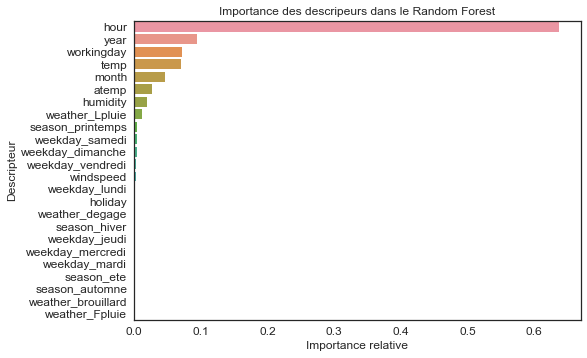

In [33]:
# Indices triées des variables selon l'importance dans le modéle de Random Forest
indices = np.argsort(RFR2.feature_importances_)[::-1]

g = sns.barplot(y=dataset.columns[indices],
                x = RFR2.feature_importances_[indices],orient='h')
g.set_xlabel("Importance relative",fontsize=12)
g.set_ylabel("Descripteur",fontsize=12)
g.tick_params(labelsize=12)
g.set_title("Importance des descripeurs dans le Random Forest");

Il est incontestable que l'heure est un facteur important de la demande en vélos. Nous l'avons trés bien vu plus haut, en semaine il y a deux pics correspondants aux horaires de debut et de fin de journée classique de travail.
L'année est aussi un facteur important puisque en 2012 il y a eu une nette augementation significative de la demande en location par rapport à 2011. Dans les descripteurs importants, on retrouve beaucoup de ceux evoqués plus haut comme le taux d'humidité, la température... 
Il semblerait que seule la saison du printemps ou le temps légèrement pluvieux soient des indicateurs pertinents pour le modéle. 

La vitesse du vent (windspeed) ne semble donc pas être pertinente dans le modèle.

Nous allons établir un dernier modéle contenant les descripeurs les plus pertinents.

In [34]:
# Sélection des descripteurs les plus pertinents selon le Random Forest
dataset_feature_selected = dataset[["workingday","temp","atemp","humidity","year","month","hour","weather_Lpluie","season_printemps"]]
print("Estimation du RMSE de la prédiction de count avec le \
Random Forest (séléction de descripteurs), par validation croisée : %.2f"%RMSE(RFR2,dataset_feature_selected,Y_train,cv=kfold))

Estimation du RMSE de la prédiction de count avec le Random Forest (séléction de descripteurs), par validation croisée : 63.67


En sélectionant les 9 descripteurs les plus pertinents, nous reussions à obtenir des performances similaires et même légèrement supérieures (RMSE 63.67).

### 4.3 Prédiction
#### 4.3.1 Analyse des résultats de la prédiction
Nous allons à présent estimer la performance réelle de ce modèle.
Pour cela nous allons séparer le jeu de données en un echantillon d'apprentissage (60%) et en un échantillon de validation (40%). 


In [35]:
# Separe le jeu de données en jeu d'apprentissage (60%) et de validation (40%)
X_train, X_val, Y_train, Y_val = train_test_split(dataset_feature_selected, Y_train, test_size = 0.4, random_state=random_state)

RFR2.fit(X_train, Y_train)

# Prediction pour le jeu de validation
Y_pred = RFR2.predict(X_val)

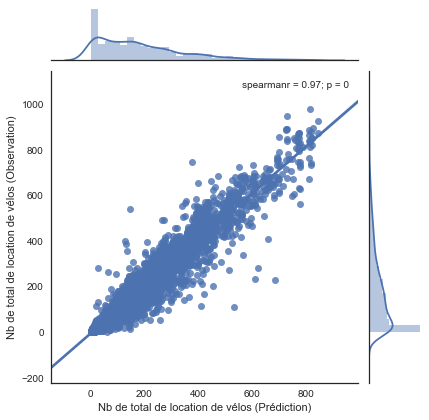

In [36]:
Y_pred = pd.Series(Y_pred,name="Y_pred",index=Y_val.index)

# Analyse des résultats de la prédiction
g = sns.jointplot(x=Y_pred,y=Y_val,kind='reg',stat_func=stats.spearmanr)
g.set_axis_labels("Nb de total de location de vélos (Prédiction)", 
                  "Nb de total de location de vélos (Observation)");

On obtient une trés forte corrélation significative de 0.97 entre les valeurs prédites et observées. On note également que la distribution des valeurs prédites est semblable à celles des valeurs observées ce qui est un bon point. Le modèle reproduit la distribution des valeurs observées.

#### 4.3.2 Analyse de l'ecart résiduel
Analysons plus en détail les erreurs de prédiction.

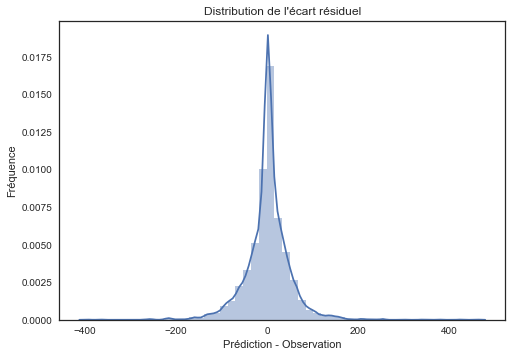

In [37]:
# Analyse de l'ecart residuel de la regression
g = sns.distplot(Y_pred-Y_val)
g.set_xlabel("Prédiction - Observation")
g.set_ylabel("Fréquence")
g.set_title("Distribution de l'écart résiduel");

La distribution de l'écart résiduel à une forme de gaussienne. La plupart des erreurs sont très faibles voire nulles. Il y a peu d'erreurs de forte amplitude, de plus elles sont également réparties de part et d'autre du 0. Ceci indique que le modèle fait de nombreuses petites erreurs plustôt que des erreurs de forte amplitude. Le modèle sous-estime et surestime le nombre de locations de vélos de manière équivalente. 

In [38]:
(Y_pred-Y_val).describe()

count    4355.000000
mean        1.303591
std        49.419618
min      -395.186919
25%       -17.272858
50%         1.600401
75%        22.245784
max       460.951587
dtype: float64

Quantitativement, la moyenne de l'écart résiduel est de 1.30 ce qui veut dire qu'en moyenne le modéle est précis à plus ou moins 2 vélos prés ! 

En conclusion le modèle est relativement précis, mais il y a de nombreuses améliorations possibles que je décrirai dans le document word.